In [92]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics
import math
from scipy import stats

## Define which experiments results we want to examine

In [8]:
RESULTS_FOLDER = "../results/Filip/Birch_1_MSE/"

In [100]:
FILENAME = "birch--triangle-100-1-20-KPP"

## Parse the custom output format into a dataframe

In [101]:
def parseNonHeuristic(line, columns):
    # drop the brackets and "non-heuristic," at the start
    line = line[15:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseHeuristic(line, columns):
    # drop the brackets
    line = line[11:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseRunResult(result, nonHeuristicDf, heuristicDf):
    line = line[1:-1]
    runner = result[0].split(":")[0]
    parseNonHeuristic(result[1])
    print("Runner", runner)
    
    return

def readResultsFile(filename):
    nonHeuristicDf = pd.DataFrame(columns=['runtime-non','mse-non','iterations-non'])
    heuristicDf = pd.DataFrame(columns=['runtime-heur','mse-achieved','mse-heur','iterations-heur','pim','stagnation'])

    with open(RESULTS_FOLDER + filename, 'r') as filehandle:
        currentRunner = None
        for line in filehandle:
            line = line[:-1]
            if ":" in line:
                currentRunner = line.split(":")[0]
            elif line.startswith("non-heuristic"):
                parsedLine = parseNonHeuristic(line, list(nonHeuristicDf.columns)),  
                nonHeuristicDf = nonHeuristicDf.append(parsedLine,ignore_index = True)
            elif line.startswith("heuristic"):
                parsedLine = parseHeuristic(line, list(heuristicDf.columns)),  
                heuristicDf = heuristicDf.append(parsedLine, ignore_index = True)
            else:
                raise Exception("Unknown line:", line)
    heuristicDf['runtime-heur'] =  heuristicDf['runtime-heur'].astype(float, errors = 'raise')
    heuristicDf['iterations-heur'] = heuristicDf['iterations-heur'].astype(int)
    heuristicDf['mse-achieved'] = heuristicDf['mse-achieved'].map(lambda x: x=="True")
    heuristicDf['mse-achieved'] =  heuristicDf['mse-achieved'].astype('bool')
    heuristicDf['stagnation'] = heuristicDf['stagnation'].map(lambda x: x=="True")
    heuristicDf['stagnation'] =  heuristicDf['stagnation'].astype(bool)
    nonHeuristicDf['runtime-non'] =  nonHeuristicDf['runtime-non'].astype(float, errors = 'raise')
    nonHeuristicDf['iterations-non'] = nonHeuristicDf['iterations-non'].astype(int)

    return nonHeuristicDf, heuristicDf

nonHeuristicDf, heuristicDf = readResultsFile(FILENAME)

In [102]:
results = nonHeuristicDf.merge(heuristicDf, left_index=True, right_index=True)
results

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
0,41.871,7484210229266891.0,3,32.691,False,7551213667510459.0,5,0,True
1,42.178,7211496880283856.0,3,38.227,False,7519329968486015.0,9,0,True
2,42.136,7138086327214976.0,3,40.317,False,7272624032253618.0,10,0,True
3,48.597,6877504089480892.0,4,40.684,False,6995462421958692.0,10,0,True
4,49.165,6550747624648164.0,4,47.937,True,6521938240966511.0,13,0,True
5,43.781,6722864002339624.0,3,32.428,False,7068170920032101.0,5,0,True
6,41.475,7529152514013192.0,3,34.014,False,7580464407160796.0,6,0,True
7,41.716,7389597241124872.0,3,35.776,False,7416453614847421.0,7,0,True
8,41.379,7699033049328656.0,3,43.453,True,7653061177881322.0,11,0,True
9,40.471,7647621687090102.0,3,37.847,False,7728722331125092.0,9,0,True


# Calculate average speedup

As stated in the report only take a look at the replicates that did not result in stagnation

In [103]:
speedupRelevant = results[results.stagnation == False]
speedupRelevant

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
14,41.867,7142374802624808.0,3,29.955,True,6993794285106532.0,3,0,False


Calculate the average speedup across all non-stagnated replicates ('Measured speedup' value reported in the report)

In [104]:
# speedup of the heuristic method
measuredSpeedup = speedupRelevant['runtime-non'].sum()/speedupRelevant['runtime-heur'].sum()
measuredSpeedup

1.397663160447721

Calculate the standard deviation of speedup (note that this will not be possible if we don't have at least 2 replicates that didn't stagnate)

In [ ]:
if(len(speedups) < 2):
    raise Exception("Should not continue only a single non-stagnated replicate was fou")

In [105]:
speedups = speedupRelevant['runtime-non'] / speedupRelevant['runtime-heur']
statistics.stdev(speedups)

StatisticsError: variance requires at least two data points

Calculate the proportion of replicates that stagnated

In [106]:
# proportion stagnated
len(results[results.stagnation == True])/len(results)

0.95

Take a look at the distribution of speedups of non-stagnated replicates - the base for significance testing

(array([1., 0., 1., 2., 1., 3., 3., 0., 1., 4.]),
 array([0.79401828, 1.04954006, 1.30506184, 1.56058362, 1.81610541,
        2.07162719, 2.32714897, 2.58267075, 2.83819253, 3.09371431,
        3.3492361 ]),
 <a list of 10 Patch objects>)

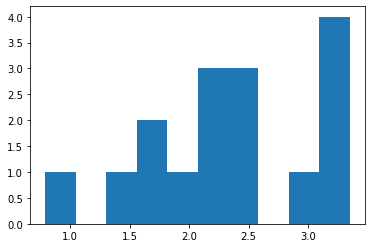

In [27]:
plt.hist(speedups)

## Significance tests

Use speedup for each replicate, only include the replicates that did not stagnate

In [68]:
speedups

0     2.500768
1     3.296790
2     2.526065
4     1.987960
6     1.683878
7     3.293865
8     2.154152
9     3.349236
12    2.244462
13    0.794018
14    2.244182
15    1.324112
16    2.382927
17    3.206684
18    1.652904
19    2.858337
dtype: float64

We can use the ditribution of of our replicates to find the probability of getting reported result value

In [81]:
# Take the value they reported and substitute it here
REPORTED_SPEEDUP_VALUE = 3.05
# significance level
alpha = 0.05
# seed for reproducibility
seed = 12345

### Approach 1: Using CLT to get normal distribution

As the data might not be normal we sample and do mean

(array([ 16.,  26.,  82., 166., 209., 228., 160.,  84.,  23.,   6.]),
 array([2.03867736, 2.09988002, 2.16108269, 2.22228535, 2.28348802,
        2.34469068, 2.40589334, 2.46709601, 2.52829867, 2.58950134,
        2.650704  ]),
 <a list of 10 Patch objects>)

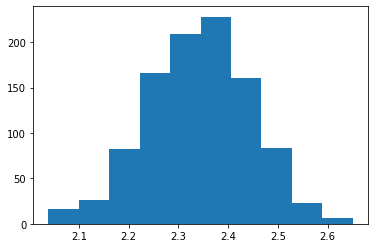

In [83]:
import numpy as np

# sample 50 items 1000 times
n = 50
sampleTimes = 1000

sampleNumber = 0
means = []
while sampleNumber < sampleTimes: 
    sampleMean = np.mean(np.random.choice(speedups,n))
    means.append(sampleMean)
    sampleNumber += 1

plt.hist(means)

In [84]:
criticalValue = stats.t.ppf(1-alpha, n-1)
criticalValue

1.6765508919142629

In [97]:
overallMeasuredMean = np.mean(means)
testStatistic = (overallMeasuredMean - REPORTED_SPEEDUP_VALUE)/(std/math.sqrt(1000))
pValue = stats.t.sf(abs(testStatistic), df=n-1)
# store the significance result for later
cltApproachSignificant = pValue < alpha
pValue

2.1127584633298964e-33

### Approach 2: Assuming t-test assumptions are met

Alternatively using the samples we have only, assuming t-test assumptions are met

In [86]:
std = statistics.stdev(speedups)
std

0.7495431483975487

In [87]:
N = len(speedups)

testStatistic = (measuredSpeedup - REPORTED_SPEEDUP_VALUE)/(std/math.sqrt(N))
print("t-Test statistic:", abs(testStatistic))

t-Test statistic: 5.044630943565985


In [98]:
criticalValue = stats.t.ppf(1-alpha, N)
print("Critical value for current statistic and alpha=0.05: ", criticalValue)
# calculate our p-value
pValue = stats.t.sf(abs(testStatistic), df=N-1)
print("P-value of their result coming from our distribution:", pValue)
# store significance level for later
assumingSignificant =  pValue < alpha
print("Significant difference - reject H0?:",)

Critical value for current statistic and alpha=0.05:  1.74588367627624
P-value of their result coming from our distribution: 4.451289121556042e-15
Significant difference - reject H0?:


## Verdict

In [99]:
print("Approach 1 significant:", cltApproachSignificant)
print("Approach 2 significant:", assumingSignificant)

Approach 1 significant: True
Approach 2 significant: True
